In [1]:
import pandas as pd
from constants import base_path, date_col, in_hospital
from datetime import timedelta
from download import find_latest
from matplotlib.dates import DateFormatter, DAYS_PER_MONTH, DAYS_PER_YEAR
from matplotlib.ticker import NullFormatter
from phe import plot_summary, read_csv
from plotting import per1k_formatter
from zoe import data_for_date as load_zoe
import matplotlib.pyplot as plt
import series as s

In [2]:
def load_prevalence(source, dates):
    data_path, data_date = find_latest(f'{source}_*.csv')
    data = pd.read_csv(data_path, parse_dates=[dates], index_col=[dates])
    return data.sort_index()

def plot(ax, data, column, label, with_errors=True):
    ax.plot(data.index, data[column], label=label, linestyle='dotted')
    if with_errors:
        ax.fill_between(data.index, data[f'{column}-lower-95'], data[f'{column}-upper-95'], alpha=0.2,
                        label=f'{label} 95% Confidence Interval')
        
def plot_prevalence(react, ons, zoe, hospital, start=None):
    fig, (axc, axh) = plt.subplots(2, 1, figsize=(16, 9), dpi=150, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    fig.set_facecolor('white')
    
    axh.plot(hospital.index, hospital)
    axh.set_title('Patients in hospital with COVID-19')
    axh.set_ylim((0, None))
    
    plot(axc, react, 'people', label='REACT')
    plot(axc, ons, 'number', label='ONS')
    plot(axc, zoe, 'corrected_covid_positive', label='ZOE*', with_errors=False)
    
    axc.legend(loc='upper left', framealpha=1)
    axc.set_title('Modelled number of people with COVID-19 in England')
    axc.set_ylim((0, None))

    for ax in axh, axc:
        yaxis = ax.yaxis
        yaxis.tick_right()
        yaxis.set_label_position("right")
        yaxis.set_major_formatter(per1k_formatter)

        xaxis=ax.xaxis
        xaxis.label.set_visible(False)
        xaxis.set_tick_params(labelbottom=True)
        formatter = xaxis.get_major_formatter()
        formatter.scaled[1] = '%d %b'
        formatter.scaled[DAYS_PER_MONTH] = '%b %y'

        ax.margins(x=0.01)
        ax.set_xlim((ons.index.min() if start is None else pd.to_datetime(start), 
                     max(data.index.max() for data in (react, ons, zoe, hospital))+timedelta(days=1)))
        
    fig.text(0.1, 0.06,
             '* ZOE is a UK-wide study. '
             '\nPlots by @chriswithers13, data from gov.uk and the various studies.',
             color='darkgrey')


In [3]:
react = load_prevalence('react_england', 'mid')
ons_daily = load_prevalence('ons_daily_england', 'Date')
ons_weekly = load_prevalence('ons_weekly_england', 'mid').loc[:ons_daily.index.min()]
ons = pd.concat([ons_weekly, ons_daily])
zoe = load_zoe('')

hospital_data_path, _ = find_latest('england_*.csv')
hospital = read_csv(hospital_data_path, index_col=date_col)[in_hospital].dropna()

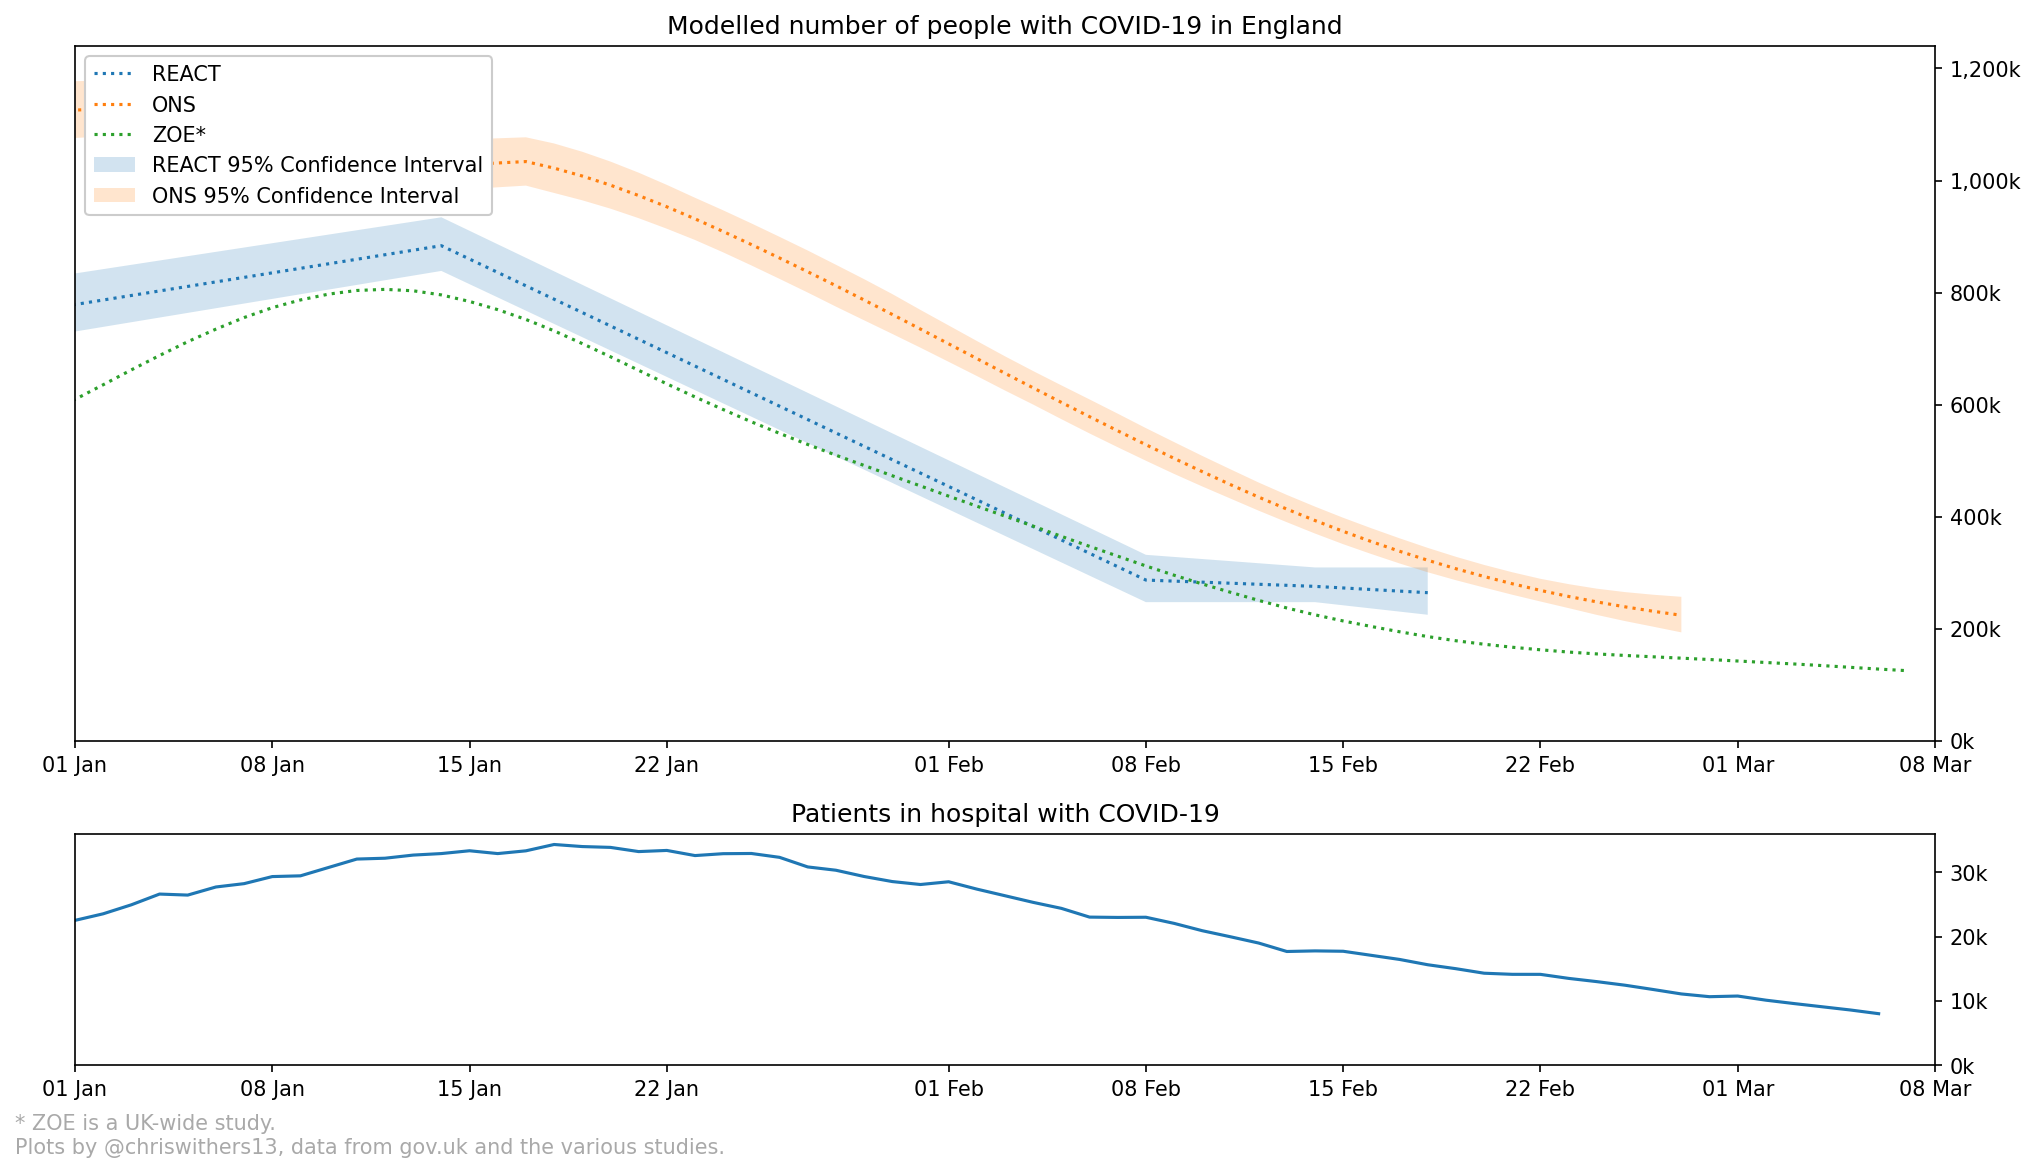

In [4]:
plot_prevalence(react, ons, zoe, hospital, start='2021-01-01')

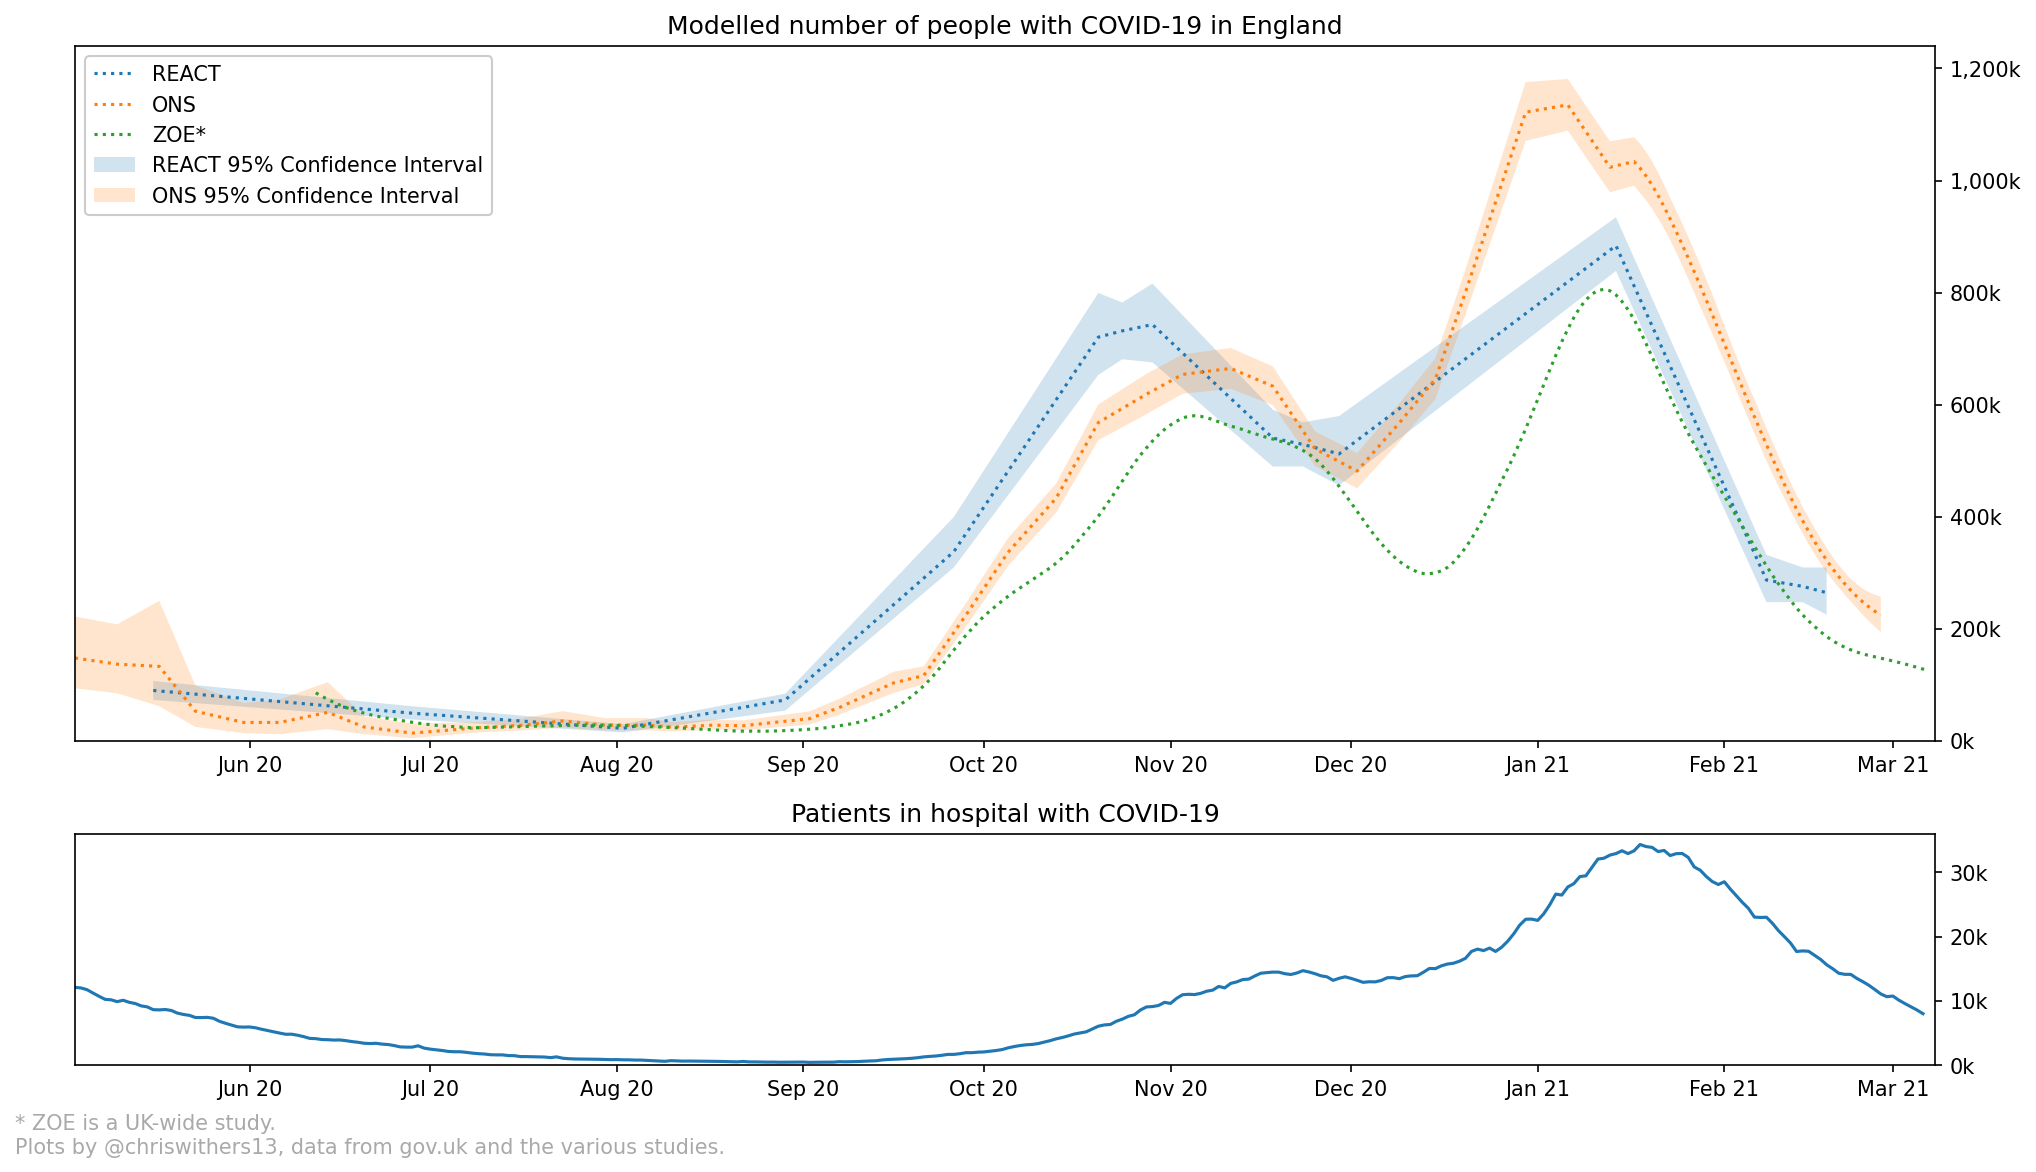

In [5]:
plot_prevalence(react, ons, zoe, hospital)